ECEN 743: Reinforcement Learning \
Deep Q-Learning \
Shaunak Shailesh Kolhe \
133008312

In [7]:
!pip install gymnasium[box2d]
!pip3 install matplotlib

In [8]:
import gymnasium as gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import cv2

# For visualization
from gymnasium.wrappers.monitoring import video_recorder
from IPython.display import HTML
import base64, io, glob

In [9]:
class ExperienceReplay:
	""" 
	Based on the Replay Buffer implementation of TD3 
	Reference: https://github.com/sfujim/TD3/blob/master/utils.py
	"""
	def __init__(self, state_dim, action_dim,max_size,batch_size,gpu_index=0):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0
		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.done = np.zeros((max_size, 1))		
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


	def add(self, state, action,reward,next_state, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.done[self.ptr] = done
		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)

	def sample(self):
		ind = np.random.randint(0, self.size, size=self.batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).long().to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.done[ind]).to(self.device)
		)



In [10]:
class QNetwork(nn.Module):
	"""
	Q Network: designed to take state as input and give out Q values of actions as output
	"""

	def __init__(self, state_dim, action_dim):
		"""
			state_dim (int): state dimenssion
			action_dim (int): action dimenssion
		"""
		super(QNetwork, self).__init__()
		self.l1 = nn.Linear(state_dim, 64)
		self.l2 = nn.Linear(64, 64)
		self.l3 = nn.Linear(64, action_dim)
		
	def forward(self, state):
		q = F.relu(self.l1(state))
		q = F.relu(self.l2(q))
		return self.l3(q)

In [11]:
class DQNAgent():

	def __init__(self,
	 state_dim, 
	 action_dim,
	 discount=0.99,
	 tau=1e-3,
	 lr=5e-4,
	 update_freq=4,
	 max_size=int(1e5),
	 batch_size=64,
	 gpu_index=0
	 ):
		"""
			state_size (int): dimension of each state
			action_size (int): dimension of each action
			discount (float): discount factor
			tau (float): used to update q-target
			lr (float): learning rate
			update_freq (int): update frequency of target network
			max_size (int): experience replay buffer size
			batch_size (int): training batch size
			gpu_index (int): GPU used for training
		"""
		self.state_dim = state_dim
		self.action_dim = action_dim
		self.discount = discount
		self.tau = tau
		self.lr = lr
		self.update_freq = update_freq
		self.max_size = max_size
		self.batch_size = batch_size
		self.device = torch.device('cuda', index=gpu_index) if torch.cuda.is_available() else torch.device('cpu')


		# Setting up the NNs
		self.Q = QNetwork(state_dim, action_dim).to(self.device)
		self.Q_target = QNetwork(state_dim, action_dim).to(self.device)
		self.optimizer = optim.Adam(self.Q.parameters(), lr=self.lr)

		# Experience Replay Buffer
		self.memory = ExperienceReplay(state_dim,1,max_size,self.batch_size,gpu_index)
		
		self.t_train = 0
	
	def step(self, state, action, reward, next_state, done):
		"""
		1. Adds (s,a,r,s') to the experience replay buffer, and updates the networks
		2. Learns when the experience replay buffer has enough samples
		3. Updates target netowork
		"""
		self.memory.add(state, action, reward, next_state, done)	   
		self.t_train += 1 
					
		if self.memory.size > self.batch_size:
			experiences = self.memory.sample()
			self.learn(experiences, self.discount) #To be implemented
		
		if (self.t_train % self.update_freq) == 0:
			self.target_update(self.Q, self.Q_target, self.tau) #To be implemented 

	def select_action(self, state, epsilon = 0.):
		if np.random.random() > epsilon:
			state = torch.tensor(state, dtype=torch.float32, device=self.device) # converting our state to pytorch tensor
			#self.Q(state) # writing updated tensor to device
			self.Q.eval()
			with torch.no_grad():
				actions=self.Q.forward(state)
			self.Q.train()
			action = torch.argmax(actions).item()
		else:
				action=np.random.choice(self.action_dim) # Random choice of action from action space of enviornment
		
		return action


	def learn(self, experiences, discount):
		"""
		TODO: Complete this block to update the Q-Network using the target network
		1. Compute target using  self.Q_target ( tar get = r + discount * max_b [Q_target(s,b)] )
		2. Compute Q(s,a) using self.Q
		3. Compute MSE loss between step 1 and step 2
		4. Update your network
		Input: experiences consisting of states,actions,rewards,next_states and discount factor
		Return: None
		""" 		
		states, actions, rewards, next_states, dones = experiences
		q_eval = self.Q(states).gather(1, actions)
		q_next = self.Q_target(next_states).detach().max(1)[0].unsqueeze(1)
		q_target = rewards + discount * q_next * (1-dones)
		loss = F.mse_loss(q_eval, q_target)
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()        
		self.target_update(self.Q, self.Q_target, self.tau)

	def target_update(self, Q, Q_target, tau):
		"""
		TODO: Update the target network parameters (param_target) using current Q parameters (param_Q)
		Perform the update using tau, this ensures that we do not change the target network drastically
		1. param_target = tau * param_Q + (1 - tau) * param_target
		Input: Q,Q_target,tau
		Return: None
		""" 
		###### TYPE YOUR CODE HERE ######
		for param_target, param_local in zip(Q_target.parameters(), Q.parameters()):
  			param_target.data.copy_(tau*param_local.data + (1.0-tau)*param_target.data)


		#param_target = tau * param_Q + (1 - tau) * param_target

**Training on Decaying Epsilon**

Decaying Epsilon curve training on NVIDIA GeForce GTX 1050
Episode Number 0 Average Episodic Reward (over 100 episodes): -121.30
Episode Number 100 Average Episodic Reward (over 100 episodes): -169.11
Episode Number 200 Average Episodic Reward (over 100 episodes): -46.49
Episode Number 300 Average Episodic Reward (over 100 episodes): -53.32
Episode Number 400 Average Episodic Reward (over 100 episodes): -69.88
Episode Number 500 Average Episodic Reward (over 100 episodes): 46.10
Episode Number 600 Average Episodic Reward (over 100 episodes): 215.75
Episode Number 700 Average Episodic Reward (over 100 episodes): 142.21
Episode Number 800 Average Episodic Reward (over 100 episodes): 241.57
Episode Number 900 Average Episodic Reward (over 100 episodes): 235.72
Episode Number 1000 Average Episodic Reward (over 100 episodes): 279.02
Episode Number 1100 Average Episodic Reward (over 100 episodes): 285.87
Episode Number 1200 Average Episodic Reward (over 100 episodes): 262.15
Episode Number 1

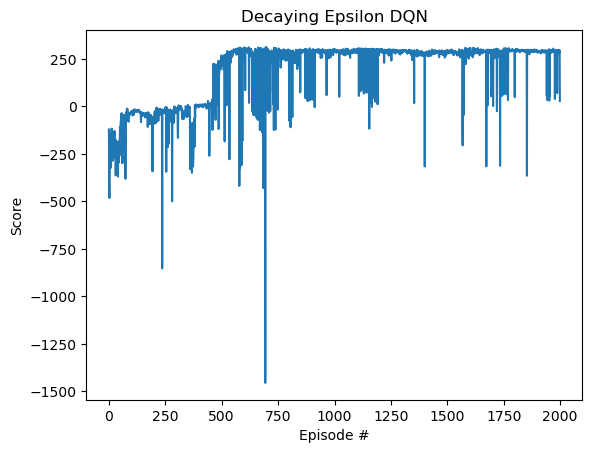

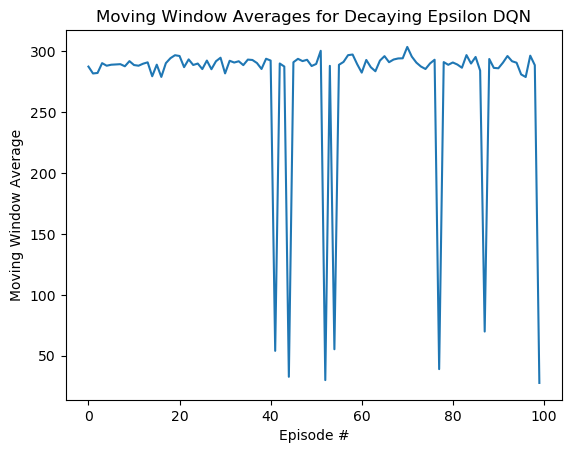

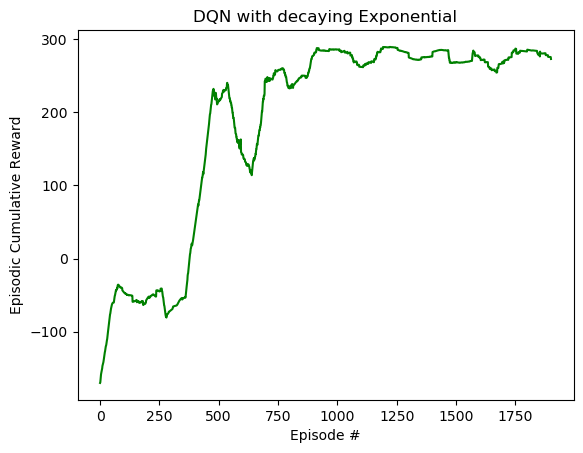

In [12]:
def decaying_epsilon_trainer():
  seed = 0              
  n_episodes = 2000
  batch_size = 64
  discount = 0.99
  lr = 5e-4                       # learning rate
  tau = 0.001                     # soft update of target network
  max_size = int(1e5)
  update_freq = 4
  gpu_index = 0
  max_eps_len = 1000
  #exploration strategy 
  # making the environment	
  env = gym.make("LunarLander-v2")  
  #setting seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed) 
  state_dim = env.observation_space.shape[0]
  action_dim = env.action_space.n 
  kwargs = {
		"state_dim":state_dim,
		"action_dim":action_dim,
		"discount":discount,
	 	"tau":tau,
	 	"lr":lr,
	 	"update_freq":update_freq,
	 	"max_size":max_size,
	 	"batch_size":batch_size,
	 	"gpu_index":gpu_index
	}	
  decaying_learner = DQNAgent(**kwargs) #Creating the DQN learning agent  
  moving_window = deque(maxlen=100)

  reward_store = []  

  epsilon_start = 1               # start value of epsilon
  epsilon_end = 0.01              # end value of epsilon
  epsilon_decay = 0.995           # decay value of epsilon	  

  epsilon_by_step = lambda step: float(epsilon_end+(epsilon_start - epsilon_end)*np.exp(-1. * step / epsilon_decay))

  print("Decaying Epsilon curve training on " + torch.cuda.get_device_name())
	 
  for e in range(n_episodes):
    state, _ = env.reset(seed=seed)
    curr_reward = 0
    for t in range(max_eps_len):
      action = decaying_learner.select_action(state, epsilon_by_step(t)) #To be implemented
      n_state,reward,terminated,truncated,_ = env.step(action)
      done = terminated or truncated 
      decaying_learner.step(state, action, reward, n_state, done) #To be implemented
      state = n_state
      curr_reward += reward
      if done:
        break
    reward_store.append(curr_reward)
    moving_window.append(curr_reward)

    if np.mean(moving_window) > 200.0:
      torch.save(decaying_learner.Q.state_dict(), 'Best_State_Lunar.pth')

    if e % 100 == 0:
      print('Episode Number {} Average Episodic Reward (over 100 episodes): {:.2f}'.format(e, np.mean(moving_window)))



	###### TYPE YOUR CODE HERE ######
  plt.plot(np.arange(len(reward_store)), reward_store)
  plt.ylabel('Score')
  plt.xlabel('Episode #')
  plt.title('Decaying Epsilon DQN')
  plt.show()

  plt.plot(np.arange(len(moving_window)), moving_window)
  plt.ylabel('Moving Window Average')
  plt.xlabel('Episode #')
  plt.title('Moving Window Averages for Decaying Epsilon DQN')
  plt.show()

  averages = []
  window_size=100

  for i in range(len(reward_store) - window_size + 1):	
    window = reward_store[i:i+window_size]
    average = sum(window) / window_size
    averages.append(average)

  plt.plot(averages, color='g')
  plt.ylabel('Episodic Cumulative Reward')
  plt.xlabel('Episode #')
  plt.title('DQN with decaying Exponential')
  plt.show()
		#################################

decaying_epsilon_trainer()

In [15]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter('LunarLander.mp4', fourcc, 30, (600, 400))
    agent.Q.load_state_dict(torch.load('Best_State_Lunar.pth'))
    state, _ = env.reset()
    print(state.shape)
    done = False
    while not done:
        frame = env.render()
        video.write(frame)
        
        action = agent.select_action(state)

        n_state,reward,terminated,truncated,_ = env.step(action)
        done = terminated or truncated 
        agent.step(state, action, reward, n_state, done) #To be implemented
        state = n_state       
    env.close()
    video.release()

In [16]:
recording_agent = DQNAgent(state_dim=8, action_dim=4)
show_video_of_model(recording_agent, 'LunarLander-v2')

(8,)
